In [1]:
import pandas as pd

reviews = pd.read_csv('reviews.csv')
reviews.info()
reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5006 entries, 0 to 5005
Data columns (total 3 columns):
author    5006 non-null object
review    5006 non-null object
rating    5006 non-null float64
dtypes: float64(1), object(2)
memory usage: 117.5+ KB


,author,review,rating
0,Dennis_Schwartz,"in my opinion , a movie reviewer's most import...",0.1
1,Dennis_Schwartz,"you can watch this movie , that is based on a ...",0.2
2,Dennis_Schwartz,"this is asking a lot to believe , and though i...",0.2
3,Dennis_Schwartz,no heroes and no story are the main attributes...,0.2
4,Dennis_Schwartz,"this is not an art movie , yet i saw it an art...",0.2


In [2]:
reviews.describe()

,rating
count,5006.000000
mean,0.581422
std,0.181725
min,0.000000
25%,0.490000
50%,0.600000
75%,0.700000
max,1.000000


In [3]:
#number of reviews per author
from matplotlib import pyplot as plt
reviews.groupby('author')['author'].count().plot.bar()
plt.grid()
plt.show()

<Figure size 640x480 with 1 Axes>

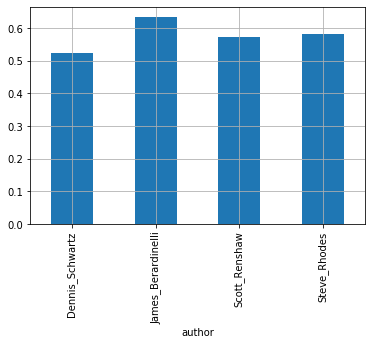

In [4]:
#mean of the rating per author
reviews.groupby('author')['rating'].mean().plot.bar()
plt.grid()
plt.show()

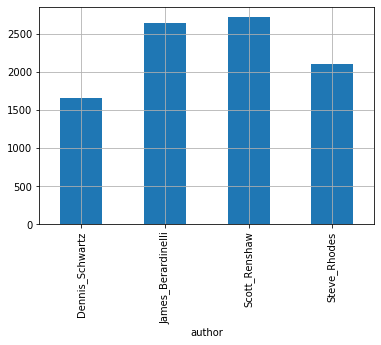

In [5]:
#average length of reviews per author
#introduce a review_length
reviews['review_length'] = reviews['review'].apply(len)
reviews.groupby('author')['review_length'].mean().plot.bar()
plt.grid()
plt.show()

In [6]:
#create the training set and test set
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(123)
reviews_train, reviews_test = train_test_split(reviews, test_size=0.15)

In [7]:
#represent data by bag of word
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()

x_train = count_vect.fit_transform(reviews_train['review'])
x_test = count_vect.transform(reviews_test['review'])

y_train = reviews_train['rating']
y_test = reviews_test['rating']

len(count_vect.vocabulary_)

39499

# Domanda 1

It contains 39499 words. The number of columns represent the words in the dictionary while the number of the row represent the words of the document

# Domanda 2

Positive reviews would have "positive" terms describing it. It would be great if we'd apply a Sentiment Analysis

# Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_train,y_train)

print(reg.coef_)
print(reg.intercept_)

[-0.00651761  0.00566821  0.0090334  ...  0.00282769 -0.00056078
 -0.00036791]
0.48495053707421476


# Domanda 3

The model has 39500 parameters, which are the 29499 features + theta 0

In [9]:
y_train_preds = reg.predict(x_train)
y_test_preds = reg.predict(x_test)

In [10]:
#define the MAE Mean Absolute Error
def MAE(y_true, y_pred):
    return (y_true-y_pred).abs().mean()

print('MAE of training set: {:0.4f}'.format(MAE(y_train,y_train_preds)))
print('MAE of test set: {:0.4f}'.format(MAE(y_test, y_test_preds)))

MAE of training set: 0.0000
MAE of test set: 0.1218


# Domanda 4

training set has less error, test has more. Probably the algorithm doesn't perfectly work except for the starting dataset. And so we have an overfitting

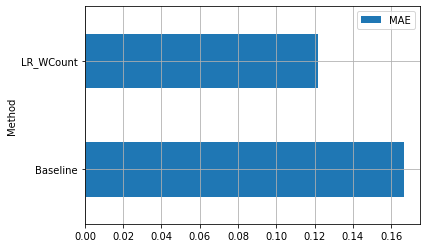

In [11]:
# We can see if we are doing good comparing it with respect of a baseline wich always predicts rating of 0.5
scores = pd.DataFrame({'Method':['Baseline','LR_WCount'], 'MAE':[MAE(y_test, 0.5), MAE(y_test,y_test_preds)]})
scores = scores.set_index('Method')
scores.plot.barh()
plt.grid()
plt.show()

# From the previous result we could say that we have an overfitting problem (training set ok, test set bad) We can try to solve this adding a regularization term

In [12]:
from sklearn.linear_model import Ridge

count_vect = CountVectorizer()

x_train = count_vect.fit_transform(reviews_train['review'])
x_test = count_vect.transform(reviews_test['review'])

y_train = reviews_train['rating']
y_test = reviews_test['rating']

lr = Ridge()
lr.fit(x_train, y_train)

y_train_pred_rg = lr.predict(x_train)
y_test_pred_rg = lr.predict(x_test)

print("MAE on the training set: {:0.4f}".format(MAE(y_train,y_train_pred_rg)))
print("MAE on the test set: {:0.4f}".format(MAE(y_test,y_test_pred_rg)))

MAE on the training set: 0.0398
MAE on the test set: 0.1017


# Domanda 5

We might get underfitting. Training got worse but test got better. This is a good compromise since we need good results on the test set

# Domanda 6

La norma del regressore regolarizzato sarà più piccola visto che alcuni parametri theta verranno posti a zero in modo da minimizzare il costo

In [13]:
# norma l2

c = lr.coef_

l2lr = np.sqrt(c**2).sum()
print(l2lr)

k = reg.coef_
l2reg = np.sqrt(k**2).sum()
print(l2reg)

46.087174360920315
115.70048241262306


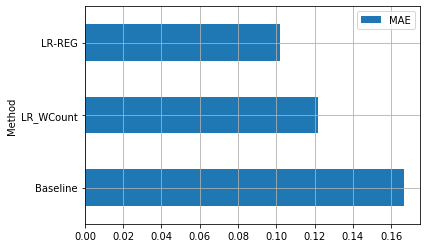

In [14]:
new_score = pd.Series({'MAE':MAE(y_test, y_test_pred_rg)},name='LR-REG')
scores = scores.append(new_score)
scores.plot.barh()
plt.grid()
plt.show()

# Problems

We got some problem since long and short reviews will get different representation because there is no normalization
Frequent words might dominate this representation. We can solve this using TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
tf = TfidfTransformer()

x_train_count = count_vect.fit_transform(reviews_train['review'])
x_train = tf.fit_transform(x_train_count)

x_test_count = count_vect.transform(reviews_test['review'])
x_test = tf.transform(x_test_count)

lr = Ridge()
lr.fit(x_train, y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print('MAE on training: {:0.4f}'.format(MAE(y_train, y_train_pred)))
print('MAE on test: {:0.4f}'.format(MAE(y_test, y_test_pred)))

MAE on training: 0.0560
MAE on test: 0.0955


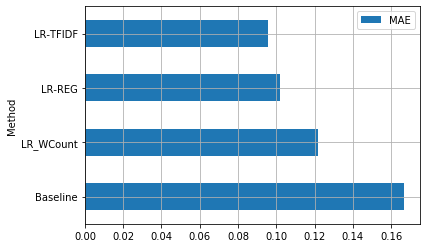

In [16]:
new_score = pd.Series({'MAE':MAE(y_test, y_test_pred)}, name='LR-TFIDF')
scores = scores.append(new_score)
scores.plot.barh()
plt.grid()
plt.show()

In [17]:
def rate(text):
    feats = count_vect.transform([text])
    feats = tf.transform(feats)
    return lr.predict(feats)[0]

i = 40 #index of an arbitrary review
review = reviews_test.iloc[i]['review']
true_rating = reviews_test.iloc[i]['rating']
rating = rate(review)
print("True rating: {:0.2f}, Predicted rating: {:0.2f}".format(true_rating, rating))
print("Review: {}".format(review))

True rating: 0.70, Predicted rating: 0.72
Review: oscar wilde -- satirist , playwright , and novelist -- was one of the great figures of the late 19th century . like many artistic figures throughout history , wilde's reputation has waxed and waned with the mutation of the social climate . today , he is regarded as a literary giant , and perhaps the best playwright of the second half of the 19th century . despite an uneven script and a rather mundane , occasionally-plodding narrative , the movie is compelling , largely because wilde's life was fascinating . throw in a number of top- notch performances and , even without any flourishes , the film offers a solid two hours of entertainment , and , for anyone unfamiliar with wilde or his work , perhaps education . as is often the case with a movie that crams 15 years of history into 120 minutes ( for the non-mathematical , that's only 8 minutes per year ) , there's a lack of consistency in the tone . certain characters and subplots are sadl

# Polynomial regression

Since with many features polynomial regression can be too time consuming, we need to simplify our representation by including less words. We will include just words with a frequency of 50% or more and exclude terms wich are too frequent

In [18]:
count_vect = CountVectorizer(min_df=0.5, max_df=0.8)
x_train_count = count_vect.fit_transform(reviews_train['review'])
print(x_train_count.shape)

(4255, 37)


# Domanda 8 

choosing lower number for min_df means that we will include more non frequent words, so we can get more information. Choosing lower value for max_df means that we will delete frequent words from our dataset. 

In [19]:
#try linear regression with reduced features

count_vect = CountVectorizer(min_df=0.5, max_df=0.8)

x_train = count_vect.fit_transform(reviews_train['review'])
x_test = count_vect.transform(reviews_test['review'])

lr = Ridge()
lr.fit(x_train, y_train)

y_trainp = lr.predict(x_train)
y_testp = lr.predict(x_test)

print("MAE of train: {:0.4f}".format(MAE(y_train, y_trainp)))
print("MAE of test: {:0.4f}".format(MAE(y_test, y_testp)))

MAE of train: 0.1399
MAE of test: 0.1449


In [20]:
#polynomial regression with reduced feature

from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2)

x_train_poly = pf.fit_transform(x_train)
x_test_poly = pf.transform(x_test)

lr = Ridge()
lr.fit(x_train_poly, y_train)

y_trainp = lr.predict(x_train_poly)
y_testp = lr.predict(x_test_poly)

print("MAE of train: {:0.4f}".format(MAE(y_train, y_trainp)))
print("MAE of test: {:0.4f}".format(MAE(y_test, y_testp)))

MAE of train: 0.1302
MAE of test: 0.1430


# Domanda 9 

The process was slower than before despite the fact that we reduced the number of features. It was not worth since we didn't gain nothing.

# Logistic Regression

We will consider a review positeve if its rating is greater than 0.5, negative otherwise

In [21]:
y_train_class = (y_train>0.5).astype(int)
print(y_train[:10], y_train_class[:10])

4164    0.60
893     0.70
591     0.50
1318    0.50
4629    0.70
627     0.60
1896    0.74
4542    0.70
4672    0.70
661     0.60
Name: rating, dtype: float64 4164    1
893     1
591     0
1318    0
4629    1
627     1
1896    1
4542    1
4672    1
661     1
Name: rating, dtype: int64


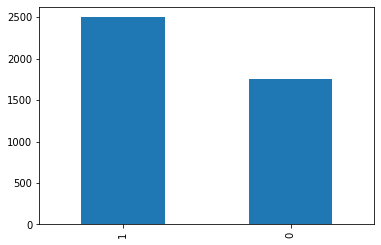

In [22]:
#transform both train and test set

y_train_class = (y_train>0.5).astype(int)
y_test_class = (y_test>0.5).astype(int)

#let's see if the values of the two classes  are balanced on the train set
y_train_class.value_counts().plot.bar()

In [23]:
from sklearn.linear_model import LogisticRegression

count_vect = CountVectorizer()
tf = TfidfTransformer()
log = LogisticRegression()

x_train = count_vect.fit_transform(reviews_train['review'])
x_train = tf.fit_transform(x_train)

x_test = count_vect.transform(reviews_test['review'])
x_test = tf.transform(x_test)

log.fit(x_train, y_train_class)

len(count_vect.vocabulary_)

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


39499

# Domanda 11

There are a total of 38 parameters, 37 coefficients and 1 intercept. Because we have 37 features

In [24]:
#predictions

y_trainp = log.predict(x_train)
y_testp = log.predict(x_test)

print("Accuracy on training: {:0.2f}".format(log.score(x_train, y_train_class)))
print("Accuracy on test: {:0.2f}".format(log.score(x_test, y_test_class)))

Accuracy on training: 0.91
Accuracy on test: 0.80


In [25]:
from sklearn.metrics import accuracy_score
print("Accuracy on training: {:0.2f}".format(accuracy_score(y_train_class,y_trainp)))
print("Accuracy on test: {:0.2f}".format(accuracy_score(y_test_class,y_testp)))

Accuracy on training: 0.91
Accuracy on test: 0.80


In [26]:
#compute the F1 score

from sklearn.metrics import f1_score
print("F1 training scores: {:0.2f} {:0.2f}".format(*f1_score(y_train_class, y_trainp, average=None)))
print("F1 test scores: {:0.2f} {:0.2f}".format(*f1_score(y_test_class,y_testp,average=None)))

F1 training scores: 0.89 0.93
F1 test scores: 0.73 0.84
